In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
import torch
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),        
    transforms.RandomHorizontalFlip(),       
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
    transforms.RandomRotation(20),            
    transforms.ToTensor(),                    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(256),                   
    transforms.CenterCrop(224),               
    transforms.ToTensor(),                   
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset)
dataset_path = 'data/CUB_200_2011/images'
dataset = ImageFolder(root=dataset_path, transform=None)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
torch.manual_seed(123)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = TransformedDataset(train_dataset, train_transforms)
val_dataset = TransformedDataset(val_dataset, val_transforms)
len(train_dataset),len(val_dataset),train_dataset[0][0],train_dataset[0][1]

(9430,
 2358,
 tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  
    nn.Linear(num_ftrs, 200)  
)
initial_state = copy.deepcopy(model.state_dict())
for param in model.parameters():
    param.requires_grad = True
model = model.to(device)
print(device)

c:\anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cuda


In [4]:
import matplotlib.pyplot as plt
def train(model,train_dataset,val_dataset,batch_size=32,lr=0.0001,epoch=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
    val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
    losses=[]
    train_acces=[]
    val_acces=[]
    best_acc=0
    best_epoch=0
    for i in range(epoch):
        model.train()
        running_loss = 0
        running_correct = 0
        total_train = 0
        for batch in train_dataloader:
            img,label=batch
            optimizer.zero_grad()
            img=img.to(device)
            label=label.to(device)
            output=model(img)
            train_loss=criterion(output,label)
            train_loss.backward()
            optimizer.step()
            running_loss += train_loss.item() * img.size(0)
            _, predicted = torch.max(output, 1)
            running_correct += (predicted == label).sum().item()
            total_train += label.size(0)
            train_loss = running_loss / total_train
        train_acc = running_correct / total_train
        losses.append(train_loss)
        train_acces.append(train_acc)
        model.eval()
        val_loss = 0
        correct = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_dataloader:
                img, label = batch
                img = img.to(device)
                label = label.to(device)
                output = model(img)
                loss = criterion(output, label)
                val_loss += loss.item() * img.size(0)
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total_val += label.size(0)
        val_epoch_loss = val_loss / total_val
        val_epoch_acc = correct / total_val
        val_acces.append(val_epoch_acc)
        print(f'Epoch [{i+1}/{epoch}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_epoch = i
            best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Best epoch: {best_epoch+1} with accuracy: {best_acc:.4f}')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Loss over Epochs')
    plt.plot(losses, label='Train Loss')
    plt.plot(val_acces, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
            
    plt.subplot(1, 2, 2)
    plt.title('Accuracy over Epochs')
    plt.plot(train_acces, label='Train Accuracy')
    plt.plot(val_acces, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    model.load_state_dict(best_model_wts)
    return model

Testing with learning rate: 0.001 and batch size: 16
Epoch [1/100], Train Loss: 5.3709, Train Acc: 0.0081, Val Loss: 5.2603, Val Acc: 0.0148
Best epoch: 1 with accuracy: 0.0148
Epoch [2/100], Train Loss: 5.1426, Train Acc: 0.0112, Val Loss: 4.9520, Val Acc: 0.0204
Best epoch: 2 with accuracy: 0.0204
Epoch [3/100], Train Loss: 5.0475, Train Acc: 0.0156, Val Loss: 4.9898, Val Acc: 0.0157
Best epoch: 2 with accuracy: 0.0204
Epoch [4/100], Train Loss: 4.9706, Train Acc: 0.0215, Val Loss: 4.7828, Val Acc: 0.0288
Best epoch: 4 with accuracy: 0.0288
Epoch [5/100], Train Loss: 4.9148, Train Acc: 0.0238, Val Loss: 4.7127, Val Acc: 0.0301
Best epoch: 5 with accuracy: 0.0301
Epoch [6/100], Train Loss: 4.8317, Train Acc: 0.0296, Val Loss: 4.7017, Val Acc: 0.0373
Best epoch: 6 with accuracy: 0.0373
Epoch [7/100], Train Loss: 4.7534, Train Acc: 0.0318, Val Loss: 4.5307, Val Acc: 0.0441
Best epoch: 7 with accuracy: 0.0441
Epoch [8/100], Train Loss: 4.6839, Train Acc: 0.0381, Val Loss: 4.3226, Val Acc

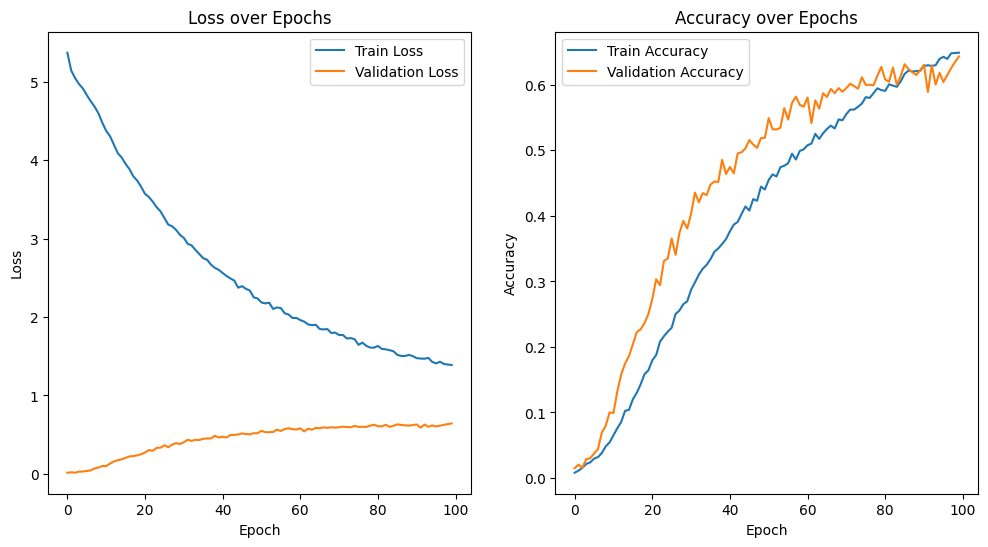

New best accuracy: 0.6433418150975403 with learning rate 0.001 and batch size 16
Testing with learning rate: 0.001 and batch size: 32


/home/nvidia/anaconda3/envs/agcl/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Train Loss: 5.3796, Train Acc: 0.0067, Val Loss: 5.1612, Val Acc: 0.0110
Best epoch: 1 with accuracy: 0.0110
Epoch [2/100], Train Loss: 5.1514, Train Acc: 0.0137, Val Loss: 5.0056, Val Acc: 0.0153
Best epoch: 2 with accuracy: 0.0153
Epoch [3/100], Train Loss: 5.0320, Train Acc: 0.0161, Val Loss: 4.9220, Val Acc: 0.0263
Best epoch: 3 with accuracy: 0.0263
Epoch [4/100], Train Loss: 4.9262, Train Acc: 0.0229, Val Loss: 4.7168, Val Acc: 0.0344
Best epoch: 4 with accuracy: 0.0344
Epoch [5/100], Train Loss: 4.8415, Train Acc: 0.0247, Val Loss: 4.5593, Val Acc: 0.0437
Best epoch: 5 with accuracy: 0.0437
Epoch [6/100], Train Loss: 4.7594, Train Acc: 0.0316, Val Loss: 4.5216, Val Acc: 0.0483
Best epoch: 6 with accuracy: 0.0483
Epoch [7/100], Train Loss: 4.6710, Train Acc: 0.0402, Val Loss: 4.3096, Val Acc: 0.0636
Best epoch: 7 with accuracy: 0.0636
Epoch [8/100], Train Loss: 4.5742, Train Acc: 0.0497, Val Loss: 4.1969, Val Acc: 0.0729
Best epoch: 8 with accuracy: 0.0729
Epoch [9

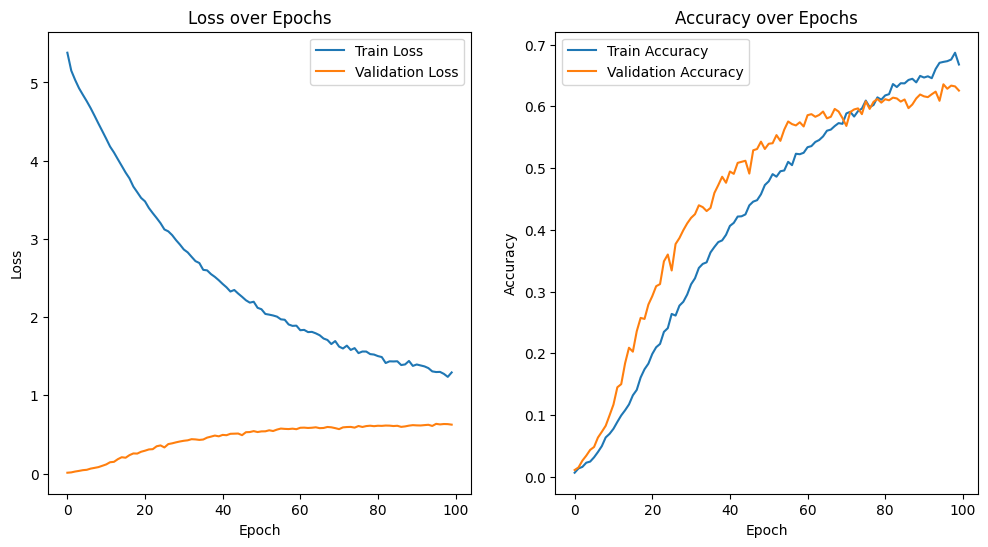

Testing with learning rate: 0.001 and batch size: 64
Epoch [1/100], Train Loss: 5.3190, Train Acc: 0.0089, Val Loss: 5.1647, Val Acc: 0.0182
Best epoch: 1 with accuracy: 0.0182
Epoch [2/100], Train Loss: 5.0553, Train Acc: 0.0145, Val Loss: 4.8379, Val Acc: 0.0208
Best epoch: 2 with accuracy: 0.0208
Epoch [3/100], Train Loss: 4.9265, Train Acc: 0.0230, Val Loss: 4.6858, Val Acc: 0.0284
Best epoch: 3 with accuracy: 0.0284
Epoch [4/100], Train Loss: 4.8437, Train Acc: 0.0274, Val Loss: 4.6370, Val Acc: 0.0386
Best epoch: 4 with accuracy: 0.0386
Epoch [5/100], Train Loss: 4.7479, Train Acc: 0.0351, Val Loss: 4.6272, Val Acc: 0.0348
Best epoch: 4 with accuracy: 0.0386
Epoch [6/100], Train Loss: 4.6518, Train Acc: 0.0394, Val Loss: 4.3371, Val Acc: 0.0674
Best epoch: 6 with accuracy: 0.0674
Epoch [7/100], Train Loss: 4.5819, Train Acc: 0.0471, Val Loss: 4.2328, Val Acc: 0.0640
Best epoch: 6 with accuracy: 0.0674
Epoch [8/100], Train Loss: 4.4738, Train Acc: 0.0575, Val Loss: 4.1573, Val Acc

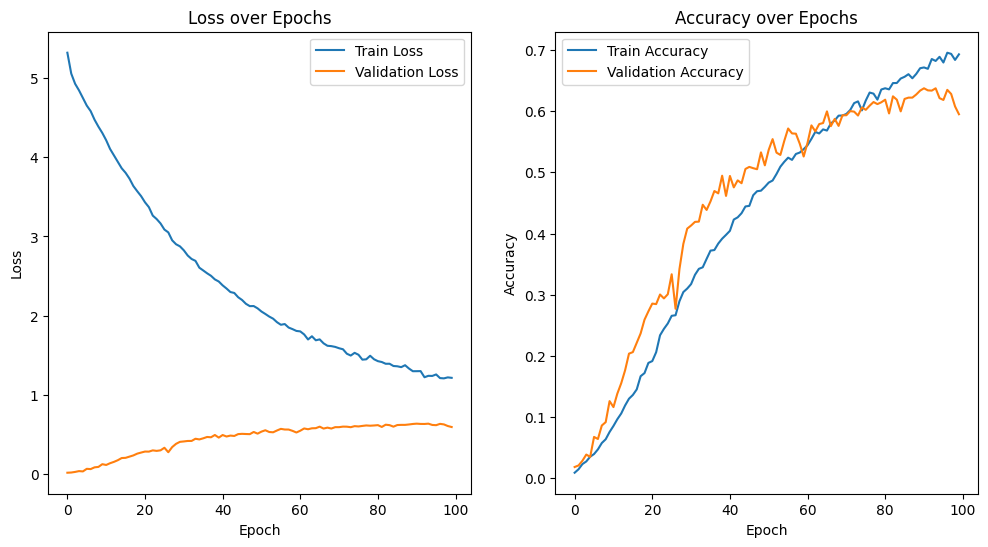

Testing with learning rate: 0.0005 and batch size: 16
Epoch [1/100], Train Loss: 5.3304, Train Acc: 0.0097, Val Loss: 5.0892, Val Acc: 0.0187
Best epoch: 1 with accuracy: 0.0187
Epoch [2/100], Train Loss: 5.0821, Train Acc: 0.0154, Val Loss: 4.8317, Val Acc: 0.0288
Best epoch: 2 with accuracy: 0.0288
Epoch [3/100], Train Loss: 4.9825, Train Acc: 0.0229, Val Loss: 4.7688, Val Acc: 0.0267
Best epoch: 2 with accuracy: 0.0288
Epoch [4/100], Train Loss: 4.9119, Train Acc: 0.0221, Val Loss: 4.6261, Val Acc: 0.0335
Best epoch: 4 with accuracy: 0.0335
Epoch [5/100], Train Loss: 4.8323, Train Acc: 0.0280, Val Loss: 4.5475, Val Acc: 0.0399
Best epoch: 5 with accuracy: 0.0399
Epoch [6/100], Train Loss: 4.7387, Train Acc: 0.0374, Val Loss: 4.3826, Val Acc: 0.0602
Best epoch: 6 with accuracy: 0.0602
Epoch [7/100], Train Loss: 4.6434, Train Acc: 0.0399, Val Loss: 4.2229, Val Acc: 0.0657
Best epoch: 7 with accuracy: 0.0657
Epoch [8/100], Train Loss: 4.5569, Train Acc: 0.0509, Val Loss: 4.2462, Val Ac

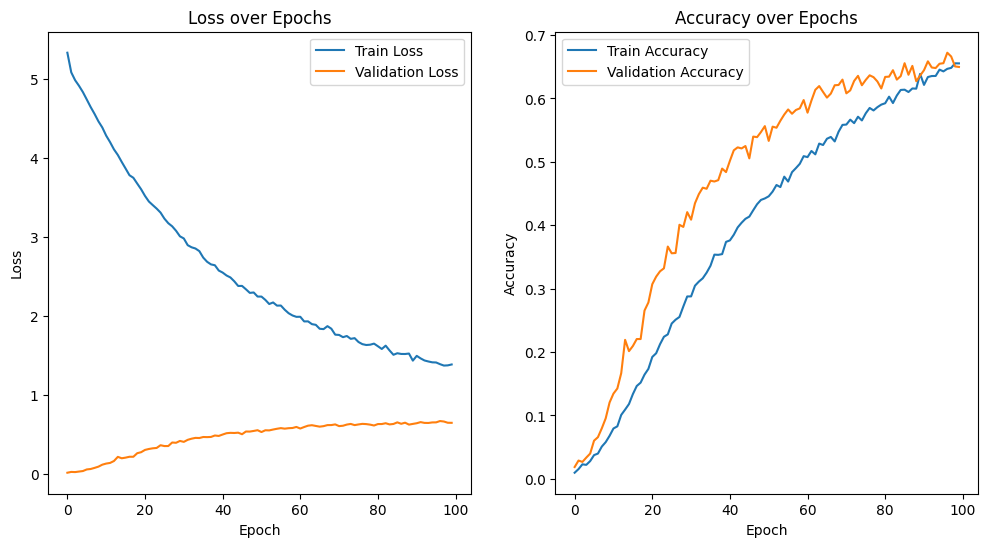

New best accuracy: 0.6721798134011875 with learning rate 0.0005 and batch size 16
Testing with learning rate: 0.0005 and batch size: 32
Epoch [1/100], Train Loss: 5.3150, Train Acc: 0.0116, Val Loss: 5.0146, Val Acc: 0.0187
Best epoch: 1 with accuracy: 0.0187
Epoch [2/100], Train Loss: 5.0478, Train Acc: 0.0157, Val Loss: 4.8830, Val Acc: 0.0254
Best epoch: 2 with accuracy: 0.0254
Epoch [3/100], Train Loss: 4.9286, Train Acc: 0.0236, Val Loss: 4.7948, Val Acc: 0.0335
Best epoch: 3 with accuracy: 0.0335
Epoch [4/100], Train Loss: 4.8215, Train Acc: 0.0288, Val Loss: 4.5425, Val Acc: 0.0428
Best epoch: 4 with accuracy: 0.0428
Epoch [5/100], Train Loss: 4.7445, Train Acc: 0.0337, Val Loss: 4.3715, Val Acc: 0.0606
Best epoch: 5 with accuracy: 0.0606
Epoch [6/100], Train Loss: 4.6462, Train Acc: 0.0368, Val Loss: 4.3098, Val Acc: 0.0636
Best epoch: 6 with accuracy: 0.0636
Epoch [7/100], Train Loss: 4.5280, Train Acc: 0.0479, Val Loss: 4.1591, Val Acc: 0.0776
Best epoch: 7 with accuracy: 0.0

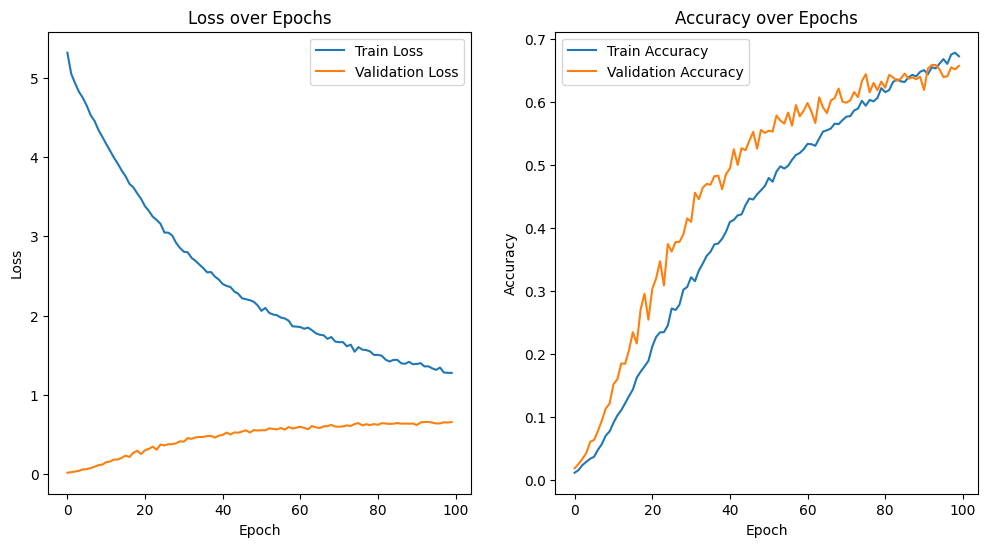

Testing with learning rate: 0.0005 and batch size: 64
Epoch [1/100], Train Loss: 5.3219, Train Acc: 0.0117, Val Loss: 5.0044, Val Acc: 0.0153
Best epoch: 1 with accuracy: 0.0153
Epoch [2/100], Train Loss: 5.0483, Train Acc: 0.0177, Val Loss: 4.8126, Val Acc: 0.0221
Best epoch: 2 with accuracy: 0.0221
Epoch [3/100], Train Loss: 4.9342, Train Acc: 0.0192, Val Loss: 4.6993, Val Acc: 0.0331
Best epoch: 3 with accuracy: 0.0331
Epoch [4/100], Train Loss: 4.8295, Train Acc: 0.0263, Val Loss: 4.5403, Val Acc: 0.0488
Best epoch: 4 with accuracy: 0.0488
Epoch [5/100], Train Loss: 4.7124, Train Acc: 0.0387, Val Loss: 4.4998, Val Acc: 0.0539
Best epoch: 5 with accuracy: 0.0539
Epoch [6/100], Train Loss: 4.6334, Train Acc: 0.0453, Val Loss: 4.4125, Val Acc: 0.0683
Best epoch: 6 with accuracy: 0.0683
Epoch [7/100], Train Loss: 4.5074, Train Acc: 0.0517, Val Loss: 4.1702, Val Acc: 0.0874
Best epoch: 7 with accuracy: 0.0874
Epoch [8/100], Train Loss: 4.4243, Train Acc: 0.0613, Val Loss: 4.0771, Val Ac

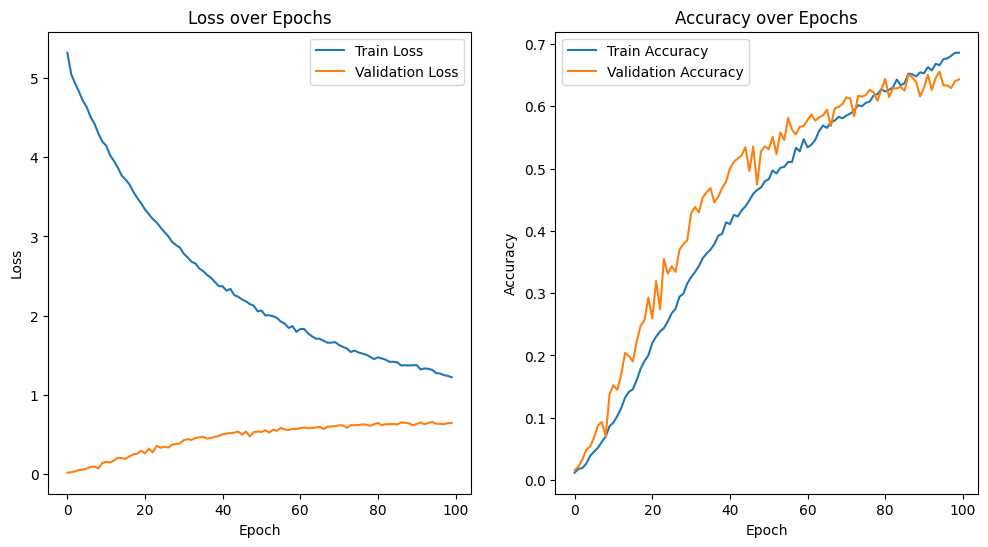

Testing with learning rate: 0.0001 and batch size: 16
Epoch [1/100], Train Loss: 5.3416, Train Acc: 0.0112, Val Loss: 5.0172, Val Acc: 0.0178
Best epoch: 1 with accuracy: 0.0178
Epoch [2/100], Train Loss: 5.1033, Train Acc: 0.0189, Val Loss: 4.7515, Val Acc: 0.0369
Best epoch: 2 with accuracy: 0.0369
Epoch [3/100], Train Loss: 4.9646, Train Acc: 0.0243, Val Loss: 4.6348, Val Acc: 0.0407
Best epoch: 3 with accuracy: 0.0407
Epoch [4/100], Train Loss: 4.8607, Train Acc: 0.0305, Val Loss: 4.5609, Val Acc: 0.0416
Best epoch: 4 with accuracy: 0.0416
Epoch [5/100], Train Loss: 4.7550, Train Acc: 0.0387, Val Loss: 4.3419, Val Acc: 0.0793
Best epoch: 5 with accuracy: 0.0793
Epoch [6/100], Train Loss: 4.6588, Train Acc: 0.0460, Val Loss: 4.2735, Val Acc: 0.0751
Best epoch: 5 with accuracy: 0.0793
Epoch [7/100], Train Loss: 4.5650, Train Acc: 0.0512, Val Loss: 4.0399, Val Acc: 0.1081
Best epoch: 7 with accuracy: 0.1081
Epoch [8/100], Train Loss: 4.4658, Train Acc: 0.0561, Val Loss: 3.9799, Val Ac

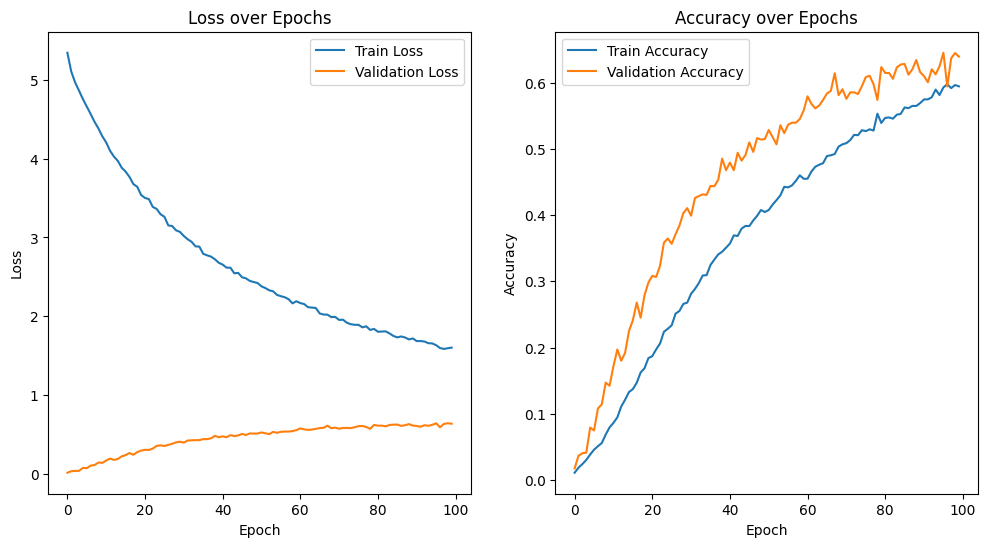

Testing with learning rate: 0.0001 and batch size: 32
Epoch [1/100], Train Loss: 5.3528, Train Acc: 0.0104, Val Loss: 5.0072, Val Acc: 0.0233
Best epoch: 1 with accuracy: 0.0233
Epoch [2/100], Train Loss: 5.1105, Train Acc: 0.0176, Val Loss: 4.8128, Val Acc: 0.0310
Best epoch: 2 with accuracy: 0.0310
Epoch [3/100], Train Loss: 4.9561, Train Acc: 0.0276, Val Loss: 4.6335, Val Acc: 0.0547
Best epoch: 3 with accuracy: 0.0547
Epoch [4/100], Train Loss: 4.8562, Train Acc: 0.0302, Val Loss: 4.4817, Val Acc: 0.0649
Best epoch: 4 with accuracy: 0.0649
Epoch [5/100], Train Loss: 4.7393, Train Acc: 0.0358, Val Loss: 4.3892, Val Acc: 0.0708
Best epoch: 5 with accuracy: 0.0708
Epoch [6/100], Train Loss: 4.6383, Train Acc: 0.0441, Val Loss: 4.2196, Val Acc: 0.0674
Best epoch: 5 with accuracy: 0.0708
Epoch [7/100], Train Loss: 4.5580, Train Acc: 0.0497, Val Loss: 4.0870, Val Acc: 0.0886
Best epoch: 7 with accuracy: 0.0886
Epoch [8/100], Train Loss: 4.4425, Train Acc: 0.0639, Val Loss: 3.9125, Val Ac

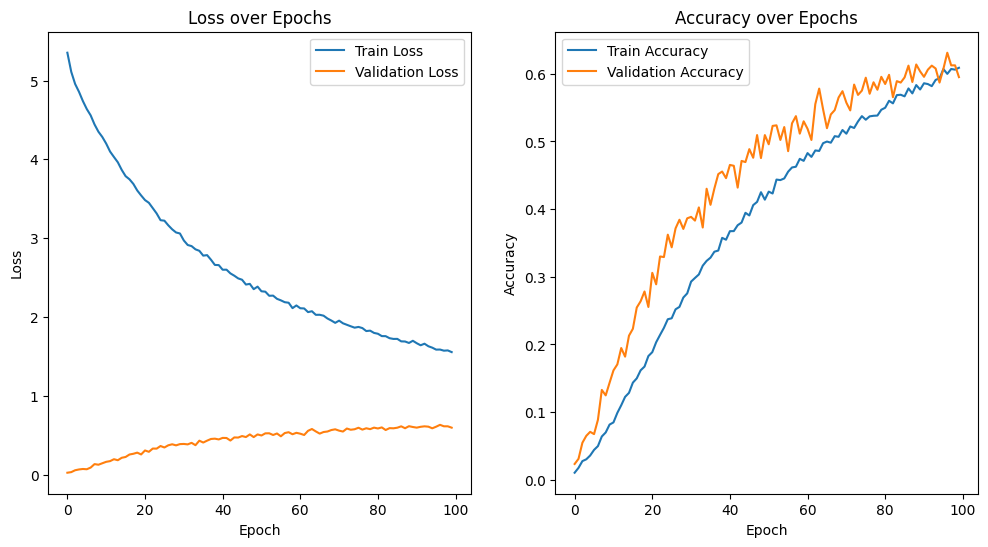

Testing with learning rate: 0.0001 and batch size: 64
Epoch [1/100], Train Loss: 5.3710, Train Acc: 0.0082, Val Loss: 5.0406, Val Acc: 0.0174
Best epoch: 1 with accuracy: 0.0174
Epoch [2/100], Train Loss: 5.1307, Train Acc: 0.0163, Val Loss: 4.8767, Val Acc: 0.0335
Best epoch: 2 with accuracy: 0.0335
Epoch [3/100], Train Loss: 4.9909, Train Acc: 0.0249, Val Loss: 4.6625, Val Acc: 0.0394
Best epoch: 3 with accuracy: 0.0394
Epoch [4/100], Train Loss: 4.8817, Train Acc: 0.0292, Val Loss: 4.5941, Val Acc: 0.0454
Best epoch: 4 with accuracy: 0.0454
Epoch [5/100], Train Loss: 4.7930, Train Acc: 0.0370, Val Loss: 4.4151, Val Acc: 0.0640
Best epoch: 5 with accuracy: 0.0640
Epoch [6/100], Train Loss: 4.6895, Train Acc: 0.0403, Val Loss: 4.3501, Val Acc: 0.0729
Best epoch: 6 with accuracy: 0.0729
Epoch [7/100], Train Loss: 4.5984, Train Acc: 0.0493, Val Loss: 4.1682, Val Acc: 0.0908
Best epoch: 7 with accuracy: 0.0908
Epoch [8/100], Train Loss: 4.5117, Train Acc: 0.0491, Val Loss: 4.1609, Val Ac

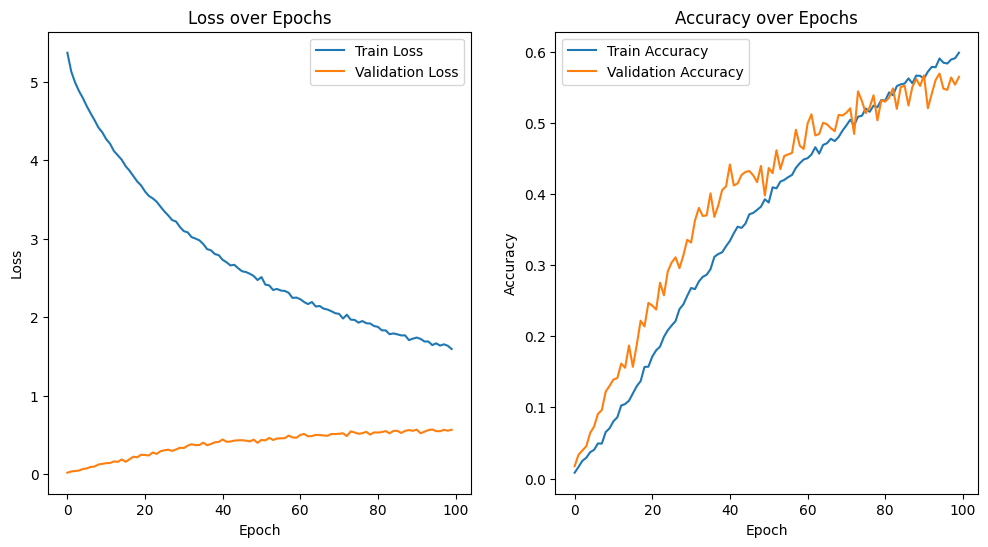

Best settings found: {'lr': 0.0005, 'batch_size': 16} with accuracy 0.6721798134011875


In [4]:
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [16, 32, 64]
best_acc = 0.0
best_settings = {}
def evaluate(model, data_set):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    data_loader=DataLoader(data_set,batch_size=batch_size,shuffle=False,num_workers=4)
    with torch.no_grad():  
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
    accuracy = correct / total
    return accuracy
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Testing with learning rate: {lr} and batch size: {batch_size}")
        model.load_state_dict(copy.deepcopy(initial_state))
        train(model,train_dataset,val_dataset,batch_size=batch_size,lr=lr,epoch=100)
        current_acc = evaluate(model, val_dataset)
        if current_acc > best_acc:
            best_acc = current_acc
            best_settings = {'lr': lr, 'batch_size': batch_size}
            print(f"New best accuracy: {best_acc} with learning rate {lr} and batch size {batch_size}")
print(f"Best settings found: {best_settings} with accuracy {best_acc}")


Epoch [1/200], Train Loss: 5.3498, Train Acc: 0.0101, Val Loss: 4.9932, Val Acc: 0.0280
Best epoch: 1 with accuracy: 0.0280
Epoch [2/200], Train Loss: 5.1004, Train Acc: 0.0178, Val Loss: 4.8202, Val Acc: 0.0301
Best epoch: 2 with accuracy: 0.0301
Epoch [3/200], Train Loss: 4.9438, Train Acc: 0.0249, Val Loss: 4.6769, Val Acc: 0.0369
Best epoch: 3 with accuracy: 0.0369
Epoch [4/200], Train Loss: 4.8466, Train Acc: 0.0339, Val Loss: 4.5267, Val Acc: 0.0577
Best epoch: 4 with accuracy: 0.0577
Epoch [5/200], Train Loss: 4.7480, Train Acc: 0.0379, Val Loss: 4.3841, Val Acc: 0.0640
Best epoch: 5 with accuracy: 0.0640
Epoch [6/200], Train Loss: 4.6513, Train Acc: 0.0414, Val Loss: 4.3028, Val Acc: 0.0835
Best epoch: 6 with accuracy: 0.0835
Epoch [7/200], Train Loss: 4.5552, Train Acc: 0.0501, Val Loss: 4.1416, Val Acc: 0.1009
Best epoch: 7 with accuracy: 0.1009
Epoch [8/200], Train Loss: 4.4707, Train Acc: 0.0597, Val Loss: 4.0201, Val Acc: 0.1060
Best epoch: 8 with accuracy: 0.1060
Epoch [9

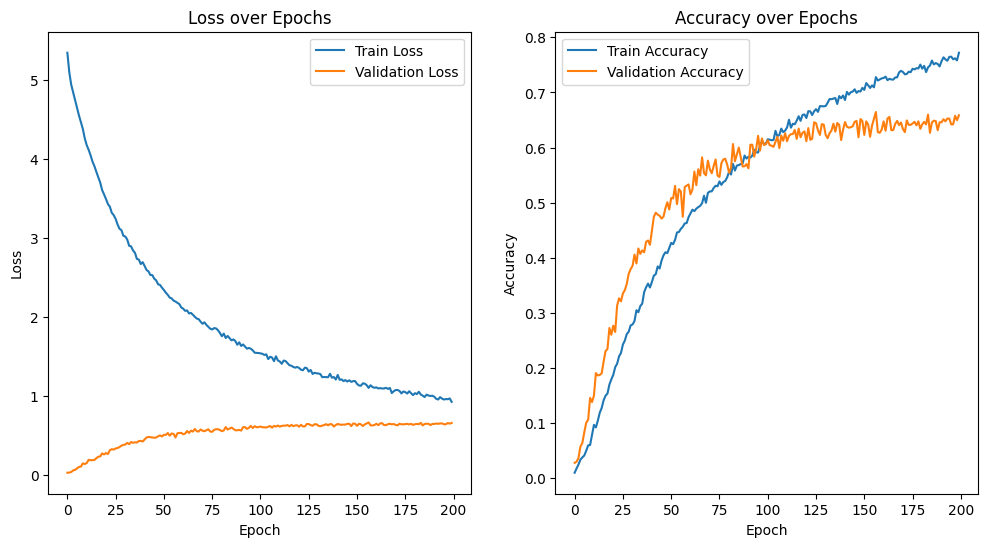

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
model.load_state_dict(copy.deepcopy(initial_state))
train(model,train_dataset,val_dataset,batch_size=32,lr=0.0001,epoch=200)